In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from keras.layers import LSTM, Activation, Dense, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def what_to_do(historical_ohlc_avg, next_day_prediction):
            mean_of_historical_ohlc_avg = historical_ohlc_avg.mean()[0]
            if next_day_prediction > mean_of_historical_ohlc_avg:
                return 'buy'
            elif next_day_prediction > mean_of_historical_ohlc_avg:
                return 'sell'
            else:
                return 'hold'

In [9]:
stock_symbol = 'MSFT'
data = yf.Ticker(stock_symbol)
historical_data = data.history(period="3y")
ohlc_avg = pd.DataFrame(historical_data.iloc[:, 0:4].mean(axis=1), columns=['OHLC_avg'])

# Split dataset into training and testing dataset
# Data older than 90 days is training dataset and remaining is testing dataset
testing_dataframe = ohlc_avg[ohlc_avg.index > datetime.utcnow() - pd.to_timedelta('90days')]
training_dataframe = ohlc_avg[ohlc_avg.index < testing_dataframe.index[0]]
print('training set shape:', training_dataframe.shape)
print('testing set shape:', testing_dataframe.shape)

training set shape: (692, 1)
testing set shape: (62, 1)


In [10]:
training_dataset = training_dataframe.values
transformer = MinMaxScaler(feature_range = (0, 1))
training_dataset_scaled_x = transformer.fit_transform(training_dataset)

training_dataset_scaled_y = training_dataset_scaled_x

X_train = []
y_train = []

for i in range(60, len(training_dataset_scaled_x)):
    X_train.append(training_dataset_scaled_x[i-60:i, :])
    y_train.append(training_dataset_scaled_y[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [29]:
stock_prediction_model = Sequential()
stock_prediction_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
stock_prediction_model.add(Dropout(0.2))
stock_prediction_model.add(LSTM(units = 50, return_sequences = True))
stock_prediction_model.add(Dropout(0.2))
stock_prediction_model.add(LSTM(units = 50, return_sequences = True))
stock_prediction_model.add(Dropout(0.2))
stock_prediction_model.add(LSTM(units = 50))
stock_prediction_model.add(Dropout(0.2))
stock_prediction_model.add(Dense(units = 1))
# stock_prediction_model.add(Activation('linear'))
stock_prediction_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit the model
stock_prediction_model.fit(X_train, y_train, epochs = 100, batch_size = 32)

# save model
# stock_prediction_model.save('stock_prediction_model')

Epoch 1/100
20/20 [==============================] - 8s 72ms/step - loss: 0.0973
Epoch 2/100
20/20 [==============================] - 1s 63ms/step - loss: 0.0107
Epoch 3/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0072
Epoch 4/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0065
Epoch 5/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0056
Epoch 6/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0051
Epoch 7/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0048
Epoch 8/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0057
Epoch 9/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0057
Epoch 10/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0048
Epoch 11/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0044
Epoch 12/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0043
Epoch 13/100
20/20 [=====

In [31]:
real_stock_price = testing_dataframe.iloc[:, 0:1].values
predicted_stock_price = []
look_ahead_predicted_stock_price = []

inputs = ohlc_avg[len(ohlc_avg) - len(testing_dataframe) - 60:].values
inputs = transformer.transform(inputs)

correct = wrong = total = 0

for i in range(60, len(inputs)):
    next_day_input = inputs[i-60:i, :]
    next_day_input = next_day_input.reshape(1, 60, 1)
    next_day_predicted_stock_price = stock_prediction_model.predict(next_day_input)
    next_day_predicted_stock_price = transformer.inverse_transform(next_day_predicted_stock_price)
    predicted_stock_price.append(next_day_predicted_stock_price[0][0])
    prediction = what_to_do(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], next_day_predicted_stock_price[0][0])
    print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(testing_dataframe.index[i-60].date()), prediction))
    real = what_to_do(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], real_stock_price[i-60])
    if prediction != real:
        wrong += 1
    else:
        correct += 1
    total += 1

print("Correct predictions:", correct)
print("Wrong predictions:", wrong)

Prediction: Tomorrow (utc:2021-02-04) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-05) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-08) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-09) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-10) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-11) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-12) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-16) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-17) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-18) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-19) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-22) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-23) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-24) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-25) it is more favourable to

In [32]:
for i in range(60, len(inputs)):
    next_day_input = inputs[i-60:i, :]
    next_day_input = next_day_input.reshape(1, 60, 1)
    next_day_predicted_stock_price = stock_prediction_model.predict(next_day_input)
    next_day_predicted_stock_price = transformer.inverse_transform(next_day_predicted_stock_price)
    look_ahead_predicted_stock_price.append(next_day_predicted_stock_price[0][0])
    inputs[i] = next_day_predicted_stock_price[0][0]
    prediction = what_to_do(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], next_day_predicted_stock_price[0][0])


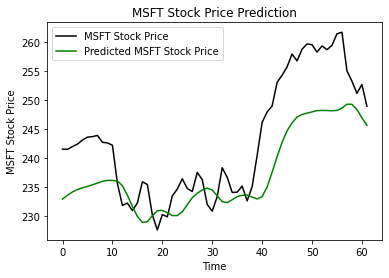

In [33]:
plt.plot(real_stock_price, color = 'black', label = '{} Stock Price'.format(stock_symbol))
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted {} Stock Price'.format((stock_symbol)))
plt.title('{} Stock Price Prediction'.format(stock_symbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock_symbol))
plt.legend()
# plt.xticks(testing_dataframe.index.values, rotation='vertical')
plt.savefig('graph.png')
plt.show()